In [14]:
import os
import pickle
import time

import numpy as np
from sklearn import svm
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
datasets_dir = 'datasets'

X_train = np.load(os.path.join(datasets_dir, 'train-authors.npy'))
y_train = np.load(os.path.join(datasets_dir, 'train-authors-labels.npy'))
X_test = np.load(os.path.join(datasets_dir, 'test-authors.npy'))
y_test = np.load(os.path.join(datasets_dir, 'test-authors-labels.npy'))
print(f'X_train: {len(X_train)} samples')
print(f'X_test: {len(X_test)} samples')

X_train: 15016 samples
X_test: 62143 samples


## Training classifiers

In [17]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
random_state = 42

X = sklearn.utils.shuffle(X_train, random_state=random_state)
y = sklearn.utils.shuffle(y_train, random_state=random_state)

models_dir = 'models'
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

print('Training SVM with various kernels\n')
for kernel in kernels:
    print(f'{kernel} ... ', end='')
    clf = svm.SVC(kernel=kernel,
                  probability=True,
                  degree=2,
                  random_state=random_state)
    tic = time.time()
    clf.fit(X, y)
    toc = time.time()
    elapsed_time = toc - tic
    print(f'Done in {elapsed_time:.3} seconds')
    
    model_path = os.path.join(models_dir, f'svm-{kernel}.pickle')
    with open(model_path, 'wb') as model_file:
        pickle.dump(clf, model_file)
    print(f'Model saved to "{model_path}"')
    print()

Training SVM with various kernels

linear ... Done in 1.5 seconds
Model saved to "models/svm-linear.pickle"

poly ... Done in 2.23 seconds
Model saved to "models/svm-poly.pickle"

rbf ... Done in 2.77 seconds
Model saved to "models/svm-rbf.pickle"

sigmoid ... Done in 4.23 seconds
Model saved to "models/svm-sigmoid.pickle"



## Evaluation

In [23]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
random_state = 42
models_dir = 'models'

df = pd.DataFrame()
roc_curves = {}

for kernel in kernels:
    model_path = os.path.join(models_dir, f'svm-{kernel}.pickle')
    with open(model_path, 'rb') as model_file:
        clf = pickle.load(model_file)

    y_pred = clf.predict_proba(X_test)[:, 1]
    score = sklearn.metrics.accuracy_score(y_test, np.round(y_pred).astype(int))
#     y_pred = clf.predict(X_test)
#     score = clf.score(X_test, y_test)

    roc_auc_score = sklearn.metrics.roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred)
    roc_curves[kernel] = (fpr, tpr)
    
    df = df.append(
        pd.Series(
            {
                'mean': score,
#             'auc score': [roc_auc_score],
#             'n of support vectors': [clf.n_support_],
            },
            name=kernel
        )
    )

df

,mean
linear,0.977536
poly,0.978582
rbf,0.978807
sigmoid,0.977310


In [19]:
plt.rcParams.update(plt.rcParamsDefault)

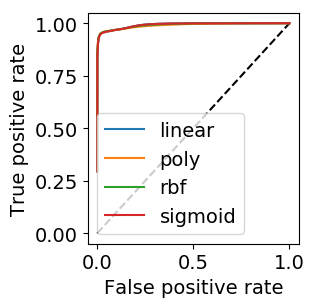

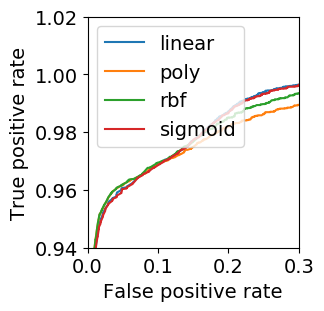

In [27]:
from cycler import cycler

# plt.rc('axes',
#        prop_cycle=cycler('marker', ['', '>', '8', 'x']))
# plt.rc('lines', color='k', linewidth=1)
plt.rc('font', size=14) 
plt.figure(figsize=(6, 3))

plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
for kernel, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=kernel, markevery=100)
# plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

# Plot zoomed
# plt.figure(2, figsize=(15, 7))
plt.figure(figsize=(6, 3))
plt.subplot(122)
plt.xlim(0, 0.3)
plt.ylim(0.94, 1.02)
plt.plot([0, 1], [0, 1], 'k--')
for kernel, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=kernel, markevery=50)
# plt.title('ROC curve (zoomed at top-left)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.legend(loc='best')

plt.show()